In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Deflategate

In [2]:
football = Table.read_table('http://inferentialthinking.com/notebooks/football.csv')
football = football.drop('Team')
football.show()

Ball,Blakeman,Prioleau
Patriots 1,11.5,11.8
Patriots 2,10.85,11.2
Patriots 3,11.15,11.5
Patriots 4,10.7,11
Patriots 5,11.1,11.45
Patriots 6,11.6,11.95
Patriots 7,11.85,12.3
Patriots 8,11.1,11.55
Patriots 9,10.95,11.35
Patriots 10,10.5,10.9


In [15]:
averages = (football.column(1) + football.column(2)) / 2
temp = football.with_column('Average at Half', averages)
temp.show(3)

Ball,Blakeman,Prioleau,Average at Half
Patriots 1,11.5,11.8,11.65
Patriots 2,10.85,11.2,11.025
Patriots 3,11.15,11.5,11.325


In [16]:
initials = np.append(np.ones(11) * 12.5, np.ones(4) * 13)
temp = temp.with_column('Estimate at Start', initials)
temp

Ball,Blakeman,Prioleau,Average at Half,Estimate at Start
Patriots 1,11.5,11.8,11.65,12.5
Patriots 2,10.85,11.2,11.025,12.5
Patriots 3,11.15,11.5,11.325,12.5
Patriots 4,10.7,11,10.85,12.5
Patriots 5,11.1,11.45,11.275,12.5
Patriots 6,11.6,11.95,11.775,12.5
Patriots 7,11.85,12.3,12.075,12.5
Patriots 8,11.1,11.55,11.325,12.5
Patriots 9,10.95,11.35,11.15,12.5
Patriots 10,10.5,10.9,10.7,12.5


In [20]:
temp = temp.with_column('Drop', temp.column(4) - temp.column(3))
temp

Ball,Blakeman,Prioleau,Average at Half,Estimate at Start,Drop
Patriots 1,11.5,11.8,11.65,12.5,0.85
Patriots 2,10.85,11.2,11.025,12.5,1.475
Patriots 3,11.15,11.5,11.325,12.5,1.175
Patriots 4,10.7,11,10.85,12.5,1.65
Patriots 5,11.1,11.45,11.275,12.5,1.225
Patriots 6,11.6,11.95,11.775,12.5,0.725
Patriots 7,11.85,12.3,12.075,12.5,0.425
Patriots 8,11.1,11.55,11.325,12.5,1.175
Patriots 9,10.95,11.35,11.15,12.5,1.35
Patriots 10,10.5,10.9,10.7,12.5,1.8


In [24]:
['Patriots'] * 11 + ['Colts'] * 4

['Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Patriots',
 'Colts',
 'Colts',
 'Colts',
 'Colts']

In [31]:
drops = temp.select('Ball', 'Drop')
drops = drops.with_column(
    'Ball', ['Patriots'] * 11 + ['Colts'] * 4
).relabeled('Ball', 'Team')
drops

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [32]:
drops.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


(0.25, 1.9)

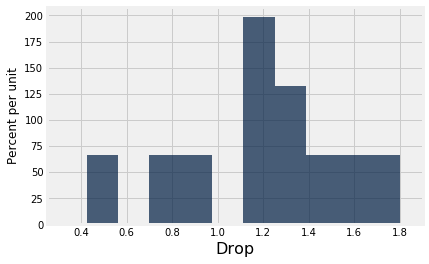

In [37]:
drops.where('Team', 'Patriots').hist(1)
plt.xlim(0.25, 1.9)

(0.25, 1.9)

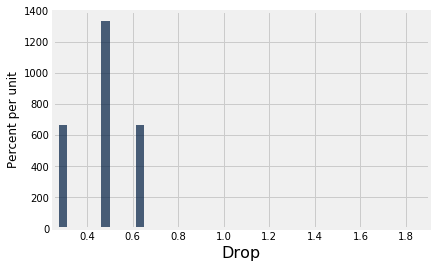

In [36]:
drops.where('Team', 'Colts').hist(1)
plt.xlim(0.25, 1.9)

Null: The Patriots and the Colts drops in pressure came from the same distribution.

Alternative: The two teams' drops in pressures did not come from the same distribution.

In [39]:
drops.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [40]:
drops.group('Team', np.average)

Team,Drop average
Colts,0.46875
Patriots,1.20227


In [46]:
def difference_in_average_drop(t):
    averages = t.group('Team', np.average).column(1)
    return abs(averages.item(0) - averages.item(1))
    
difference_in_average_drop(drops)

0.733522727272728

How would I draw more samples under the null?

In [61]:
shuffled = drops.select('Drop').sample(with_replacement=False)
sample = drops.select('Team').with_column('Drop', shuffled.column(0))
sample.show(3)

Team,Drop
Patriots,0.475
Patriots,0.275
Patriots,1.65


(0.25, 1.9)

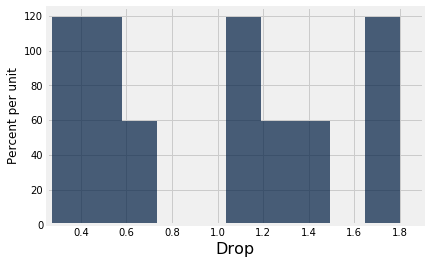

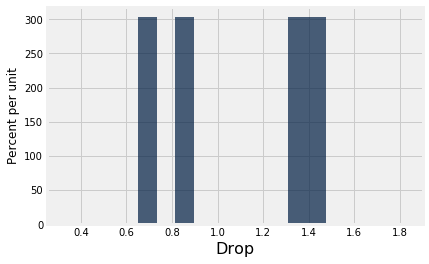

In [62]:
sample.where('Team', 'Patriots').hist(1)
plt.xlim(0.25, 1.9)

sample.where('Team', 'Colts').hist(1)
plt.xlim(0.25, 1.9)

In [63]:
difference_in_average_drop(sample)

0.11022727272727184

In [69]:
shuffled = drops.select('Drop').sample(with_replacement=False)
sample = drops.select('Team').with_column('Drop', shuffled.column(0))
difference_in_average_drop(sample)

0.2562499999999994

In [70]:
repetitions = 10000
sampled_stats = make_array()

for i in np.arange(repetitions):
    shuffled = drops.select('Drop').sample(with_replacement=False)
    sample = drops.select('Team').with_column('Drop', shuffled.column(0))
    sampled_stats = np.append(sampled_stats, difference_in_average_drop(sample))

sampled_stats

array([ 0.19545455,  0.16136364,  0.10170455, ...,  0.10284091,
        0.15284091,  0.41818182])

In [71]:
null = Table().with_column('Null distribution', sampled_stats)
null

Null distribution
0.195455
0.161364
0.101705
0.0505682
0.580114
0.382955
0.290341
0.0261364
0.707955
0.725


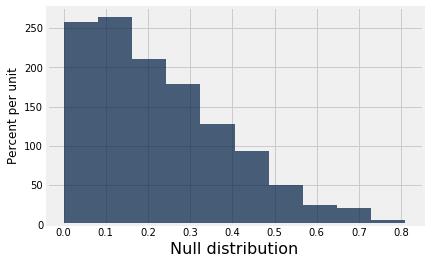

In [72]:
null.hist()

In [74]:
observed = difference_in_average_drop(drops)
observed

0.733522727272728

In [75]:
def plot_null_n_samples(n=1):
    (Table().with_column('Null distribution', sampled_stats[:n])
     .hist(bins=np.arange(0, 0.9, 0.05)))
    plt.plot([observed, observed], [0, 3])
    plt.ylim(0, 3)
    plt.show()

_ = interact(plot_null_n_samples, n=(1, 10001, 10))

In [79]:
np.count_nonzero(sampled_stats >= observed) / repetitions

0.0041